# Libraries

In [2]:
import os
import cv2
import umap
import timm
import random
import pickle
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
from collections import defaultdict
from collections import defaultdict

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

# Exploratory Data Analysis (EDA)

In [3]:
train_data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
test_data = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')

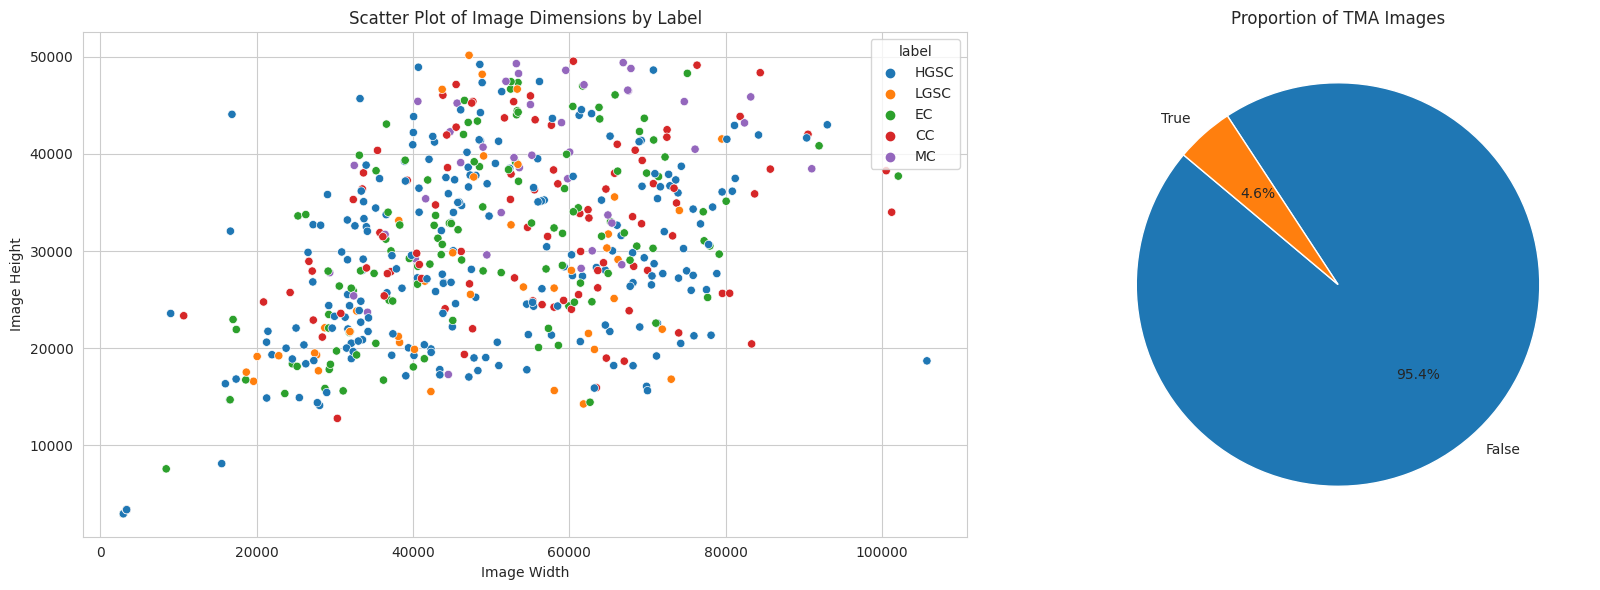

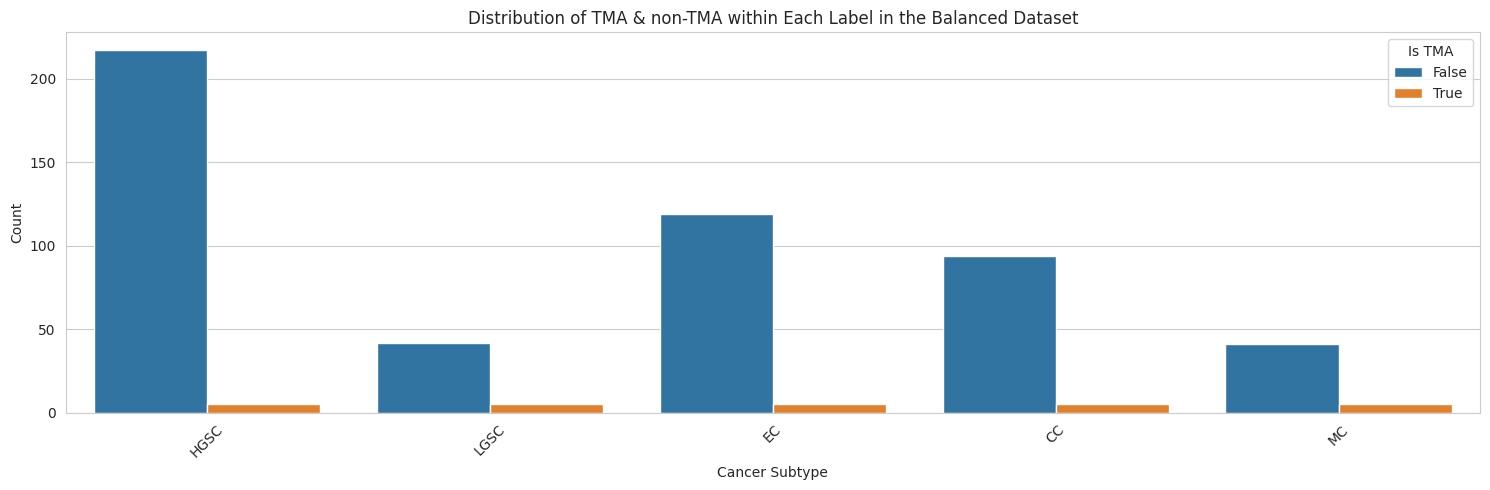

In [4]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

print()

# Prepare for multiple plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Scatter plot of image dimensions colored by label
sns.scatterplot(data=train_data, x='image_width', y='image_height', hue='label', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Label')
axes[0].set_xlabel('Image Width')
axes[0].set_ylabel('Image Height')

# Plot 2: Proportion of TMAs
tma_counts = train_data['is_tma'].value_counts()
axes[1].pie(tma_counts, labels=tma_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Proportion of TMA Images')

plt.tight_layout()
plt.show()

print()
print()

# Now we can plot the distribution of TMA and non-TMA within each label for this balanced dataset
plt.figure(figsize=(15, 5))
sns.countplot(data=train_data, x='label', hue='is_tma')
plt.title('Distribution of TMA & non-TMA within Each Label in the Balanced Dataset')
plt.xlabel('Cancer Subtype')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is TMA', loc='upper right')
plt.tight_layout()
plt.show()

The **class** distribution in the train dataset:

* HGSC: 222 images
* EC: 124 images
* CC: 99 images
* LGSC: 47 images
* MC: 46 images

**is_tma** column:

* Non-TMA: 95.35%
* TMA: 4.65%

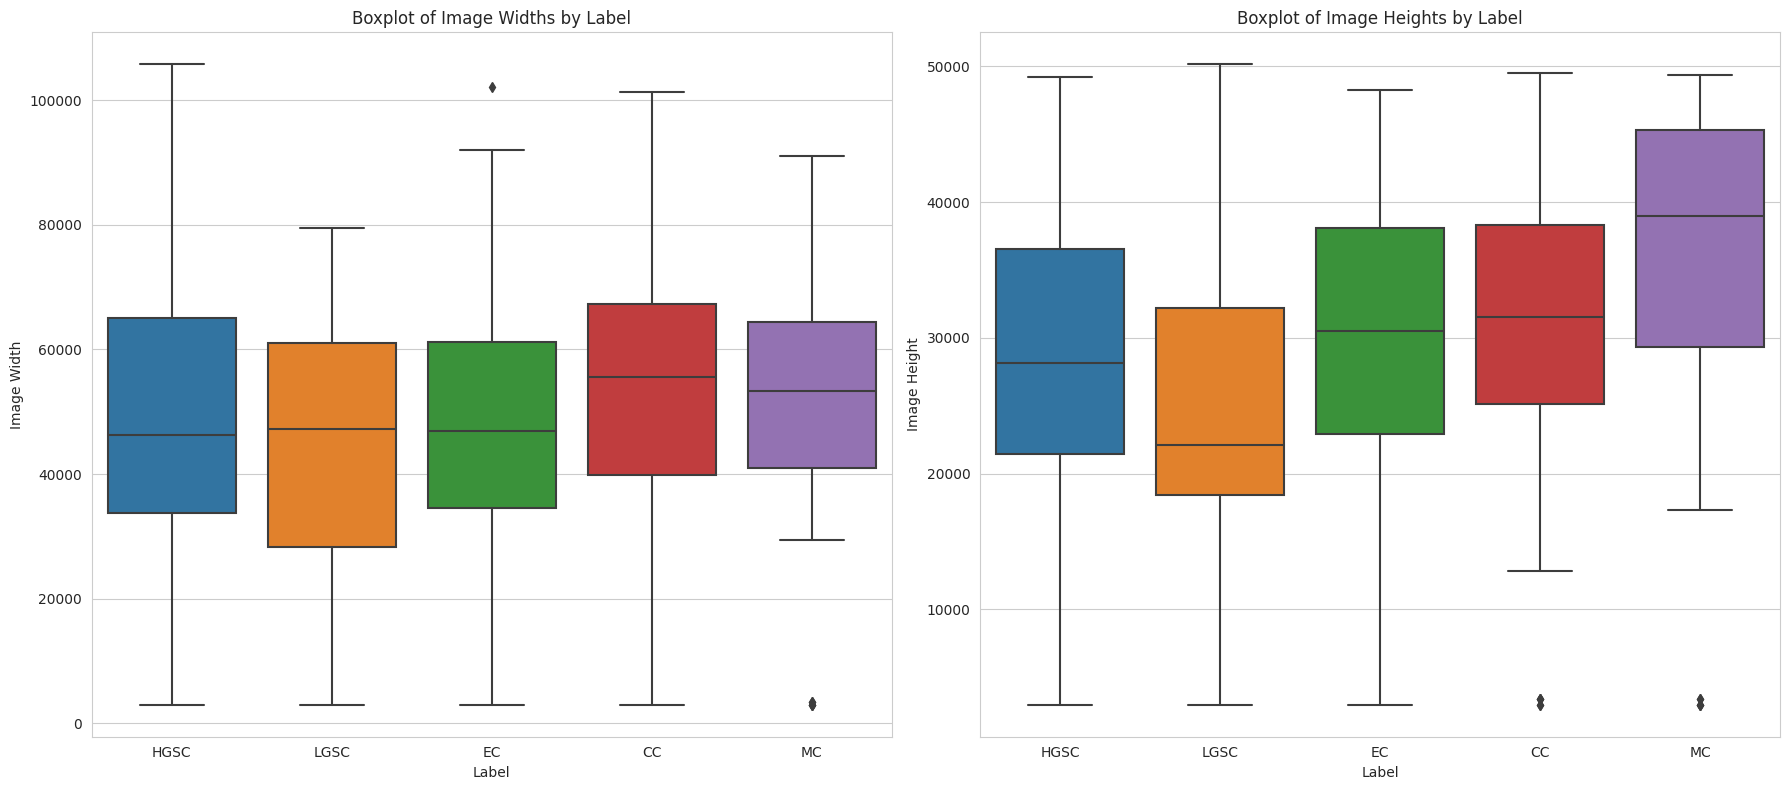

In [5]:
# Prepare for multiple sophisticated plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 3: Boxplot of image widths by label
sns.boxplot(data=train_data, x='label', y='image_width', ax=axes[0])
axes[0].set_title('Boxplot of Image Widths by Label')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Image Width')

# Plot 4: Boxplot of image heights by label
sns.boxplot(data=train_data, x='label', y='image_height', ax=axes[1])
axes[1].set_title('Boxplot of Image Heights by Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Image Height')


plt.tight_layout()
plt.show()

# Balancing Class Distributions

In [6]:
# First, we separate TMA and non-TMA images
tma_data = train_data[train_data['is_tma'] == True]
non_tma_data = train_data[train_data['is_tma'] == False]

# Since we want to keep all TMA images, let's focus on balancing the non-TMA images
# We will undersample non-TMA images to the size of the smallest class within non-TMAs
smallest_class_count = non_tma_data['label'].value_counts().min()
undersampled_non_tma_data = pd.DataFrame()

# Perform undersampling for each label within non-TMA data
for label in non_tma_data['label'].unique():
    label_data = non_tma_data[non_tma_data['label'] == label]
    undersampled_label_data = resample(label_data,
                                       replace=False, # sample without replacement
                                       n_samples=smallest_class_count, # to match smallest class count
                                       random_state=123) # reproducible results
    undersampled_non_tma_data = pd.concat([undersampled_non_tma_data, undersampled_label_data])

# Now combine the undersampled non-TMA data with the original TMA data
combined_data = pd.concat([undersampled_non_tma_data, tma_data])

# Shuffle the combined dataset
balanced_combined_data = combined_data.sample(frac=1, random_state=123).reset_index(drop=True)

# Let's check the new distribution
new_label_distribution = balanced_combined_data['label'].value_counts()
new_tma_distribution = balanced_combined_data['is_tma'].value_counts(normalize=True)

new_label_distribution, new_tma_distribution

(label
 MC      46
 CC      46
 HGSC    46
 LGSC    46
 EC      46
 Name: count, dtype: int64,
 is_tma
 False    0.891304
 True     0.108696
 Name: proportion, dtype: float64)

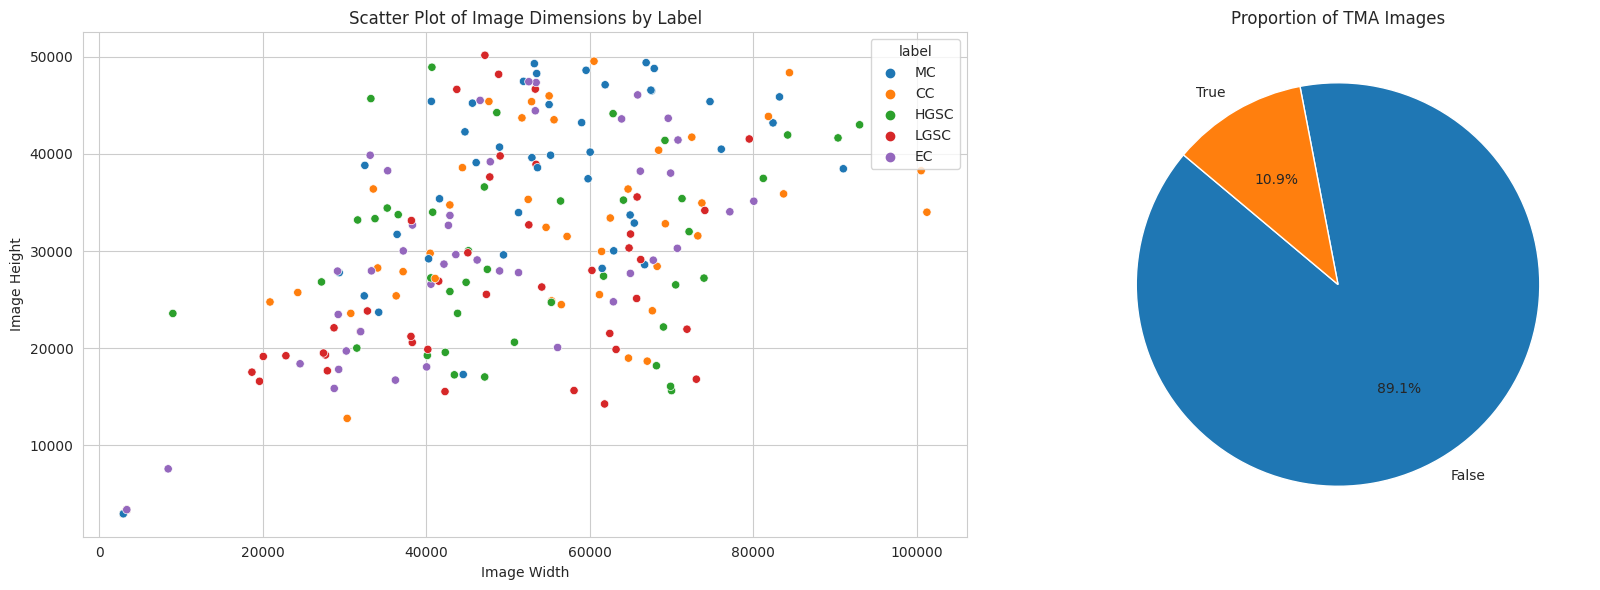

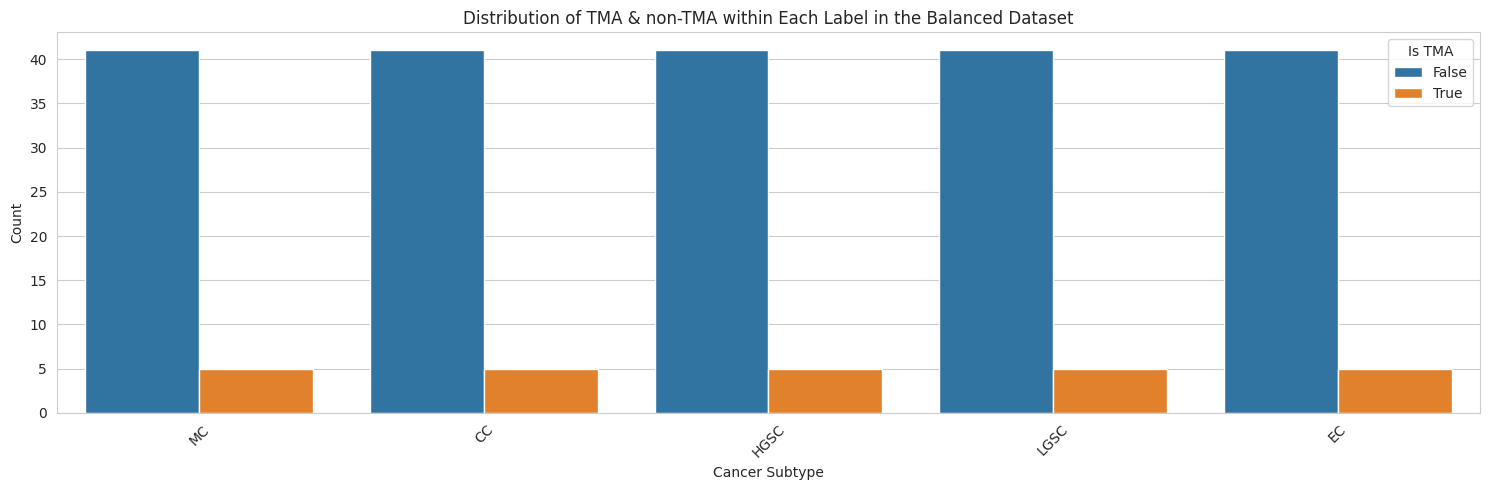

In [7]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

print()

# Prepare for multiple plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Scatter plot of image dimensions colored by label
sns.scatterplot(data=balanced_combined_data, x='image_width', y='image_height', hue='label', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Label')
axes[0].set_xlabel('Image Width')
axes[0].set_ylabel('Image Height')

# Plot 2: Proportion of TMAs
tma_counts = balanced_combined_data['is_tma'].value_counts()
axes[1].pie(tma_counts, labels=tma_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Proportion of TMA Images')

plt.tight_layout()
plt.show()

print()
print()

# Now we can plot the distribution of TMA and non-TMA within each label for this balanced dataset
plt.figure(figsize=(15, 5))
sns.countplot(data=balanced_combined_data, x='label', hue='is_tma')
plt.title('Distribution of TMA & non-TMA within Each Label in the Balanced Dataset')
plt.xlabel('Cancer Subtype')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is TMA', loc='upper right')
plt.tight_layout()
plt.show()

In [8]:
balanced_combined_data

,image_id,label,image_width,image_height,is_tma
0,56993,MC,51910,47471,False
1,16876,CC,24301,25740,False
2,37307,MC,46120,39107,False
3,17637,HGSC,2964,2964,True
4,38366,LGSC,31951,21718,False
...,...,...,...,...,...
225,64771,EC,29163,27940,False
226,41368,EC,3388,3388,True
227,38849,LGSC,60283,28011,False
228,38669,CC,41105,27185,False


## Data Augmentation for TMA images

In [ ]:
# Directory where the original TMA images are located
original_tma_dir = '/kaggle/input/UBC-OCEAN/train_images'

# Directory where augmented images will be saved
augmented_tma_dir = '/kaggle/working/augmented_TMA_images'
os.makedirs(augmented_tma_dir, exist_ok=True)

# Create an instance of the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Initialize a list to collect new DataFrame rows for augmented images
augmented_image_data = []

def augment_and_save(image_path, num_augmented, save_dir, original_label, original_image_id):
    img = load_img(image_path)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    
    # Construct the base name for augmented images
    base_name = os.path.basename(image_path).split('.')[0]
    
    i = 1  # Start naming with aug1
    for batch in datagen.flow(img_array, batch_size=1):
        new_image_id = f"{original_image_id}_aug{i}"
        new_image_path = os.path.join(save_dir, f"{new_image_id}.png")

        # Save the image to disk with the correct filename
        save_img(new_image_path, batch[0])

        # Create a new DataFrame row for each augmented image
        new_row = {
            'image_id': new_image_id,
            'label': original_label,
            'image_width': img.width,   # Assuming no change in dimensions
            'image_height': img.height,
            'is_tma': True,
            'path': new_image_path   # Add a path column 
        }
        augmented_image_data.append(new_row)

        i += 1
        if i > num_augmented:
            break  # Stop after generating the desired number of augmented images


# Loop through the TMA images and apply augmentation
for index, row in tma_data.iterrows():
    original_image_id = row['image_id']
    image_path = os.path.join(original_tma_dir, f"{original_image_id}.png")
    augment_and_save(image_path, num_augmented=10, save_dir=augmented_tma_dir, original_label=row['label'], original_image_id=original_image_id)

# Create a DataFrame from the augmented image data
augmented_image_df = pd.DataFrame(augmented_image_data)

# Add a path column to the original balanced_combined_data DataFrame
balanced_combined_data['path'] = balanced_combined_data['image_id'].apply(lambda x: f'/kaggle/input/UBC-OCEAN/train_images/{x}.png')

# Finally, combine the original balanced data with the new augmented image data
final_combined_data = pd.concat([balanced_combined_data, augmented_image_df], ignore_index=True)

# Here final_combined_data will have all the necessary information along with the paths to the images.
final_combined_data

In [19]:
final_combined_data.to_csv('final_combined_data.csv', index=False)

final_combined_data_test = pd.read_csv('/kaggle/input/final-combined/final_combined_data.csv')

final_combined_data_test

,image_id,label,image_width,image_height,is_tma,path
0,56993,MC,51910,47471,False,/kaggle/input/UBC-OCEAN/train_images/56993.png
1,16876,CC,24301,25740,False,/kaggle/input/UBC-OCEAN/train_images/16876.png
2,37307,MC,46120,39107,False,/kaggle/input/UBC-OCEAN/train_images/37307.png
3,17637,HGSC,2964,2964,True,/kaggle/input/UBC-OCEAN/train_images/17637.png
4,38366,LGSC,31951,21718,False,/kaggle/input/UBC-OCEAN/train_images/38366.png
...,...,...,...,...,...,...
475,61797_aug6,HGSC,3388,3388,True,/kaggle/working/augmented_TMA_images/61797_aug...
476,61797_aug7,HGSC,3388,3388,True,/kaggle/working/augmented_TMA_images/61797_aug...
477,61797_aug8,HGSC,3388,3388,True,/kaggle/working/augmented_TMA_images/61797_aug...
478,61797_aug9,HGSC,3388,3388,True,/kaggle/working/augmented_TMA_images/61797_aug...


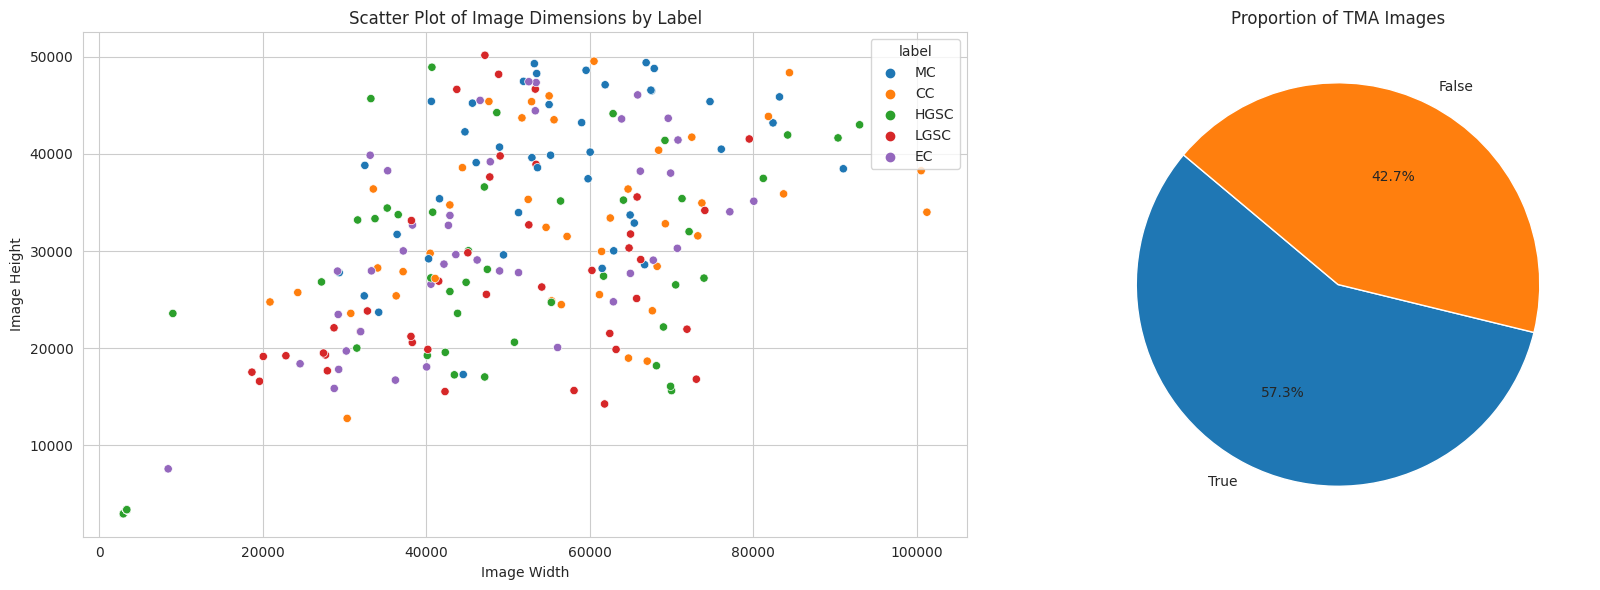

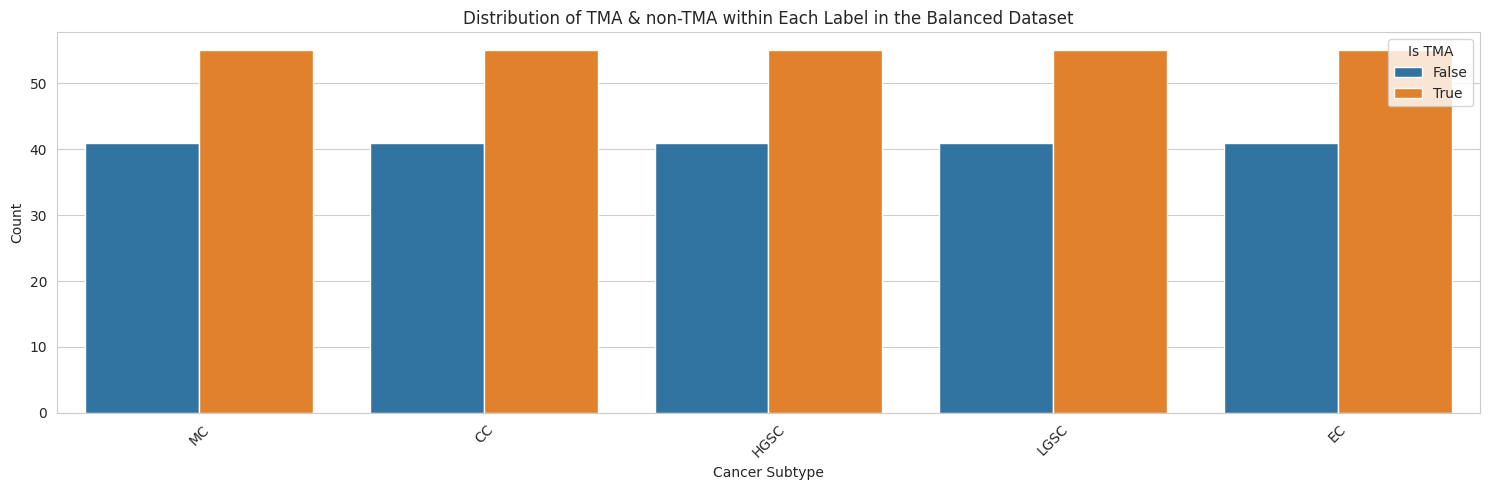

In [10]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

print()

# Prepare for multiple plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Scatter plot of image dimensions colored by label
sns.scatterplot(data=final_combined_data, x='image_width', y='image_height', hue='label', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Label')
axes[0].set_xlabel('Image Width')
axes[0].set_ylabel('Image Height')

# Plot 2: Proportion of TMAs
tma_counts = final_combined_data['is_tma'].value_counts()
axes[1].pie(tma_counts, labels=tma_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Proportion of TMA Images')

plt.tight_layout()
plt.show()

print()
print()

# Now we can plot the distribution of TMA and non-TMA within each label for this balanced dataset
plt.figure(figsize=(15, 5))
sns.countplot(data=final_combined_data, x='label', hue='is_tma')
plt.title('Distribution of TMA & non-TMA within Each Label in the Balanced Dataset')
plt.xlabel('Cancer Subtype')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is TMA', loc='upper right')
plt.tight_layout()
plt.show()

## Approach for WSI images

create dictionary of 33 keys. each key contains values:

1. path to image
2. feature vectors
3. label of original slide

In [50]:
# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Select the first 33 WSI images 
selected_images = final_combined_data[final_combined_data['is_tma'] == False].head(33)

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet50', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.2, low_saturation_threshold=20):
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Define the size for the tiles
tile_size = 1024

slide_features = {}

# Function to process a patch of the image
def process_patch(patch, model, transform):
    if is_tissue_present(patch):
        features = extract_features(patch, model, transform)
        return features
    return None

# Process each image, extract tiles, extract features, and store them
for index, row in selected_images.iterrows():
    image_path = row['path']
    label = row['label']
    tile_features = []  # List to hold the features for the current image

    # Open the image using Pillow
    with Image.open(image_path) as img:
        for y in range(0, img.height, tile_size):
            for x in range(0, img.width, tile_size):
                # Read the patch
                patch = img.crop((x, y, x + tile_size, y + tile_size))
                patch = np.array(patch)  # Convert PIL Image to NumPy array

                # Process the patch
                features = process_patch(patch, model, transform)
                if features is not None:
                    tile_features.append(features)

    # Store the extracted features and the label in the slide_features dictionary
    slide_features[image_path] = {
        'features': tile_features,
        'label': label
    }

# Now slide_features contains the feature vectors and labels for each of the 33 slides

In [92]:
with open('/kaggle/working/slide_features.pkl', 'wb') as f:
    pickle.dump(slide_features, f)

In [93]:
with open('/kaggle/input/slide-features/slide_features.pkl', 'rb') as f:
    slide_features_test = pickle.load(f)

# Multiple Instance Learning (MIL) classifier

## Dataset
Preparing data for model training

In [173]:
# Convert slide_features to a suitable format
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# Organize data by labels
data_by_label = defaultdict(list)

for features, label in data:
    data_by_label[label].append((features, label))

# data_by_label is a dictionary where each key is a label and value is a list of corresponding data points

In [176]:
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2)

    # Split train data into train and validation
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of original

    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

# Shuffle datasets
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'LGSC': 3, 'MC': 6, 'HGSC': 3, 'CC': 2, 'EC': 3}
Validation balance: {'HGSC': 2, 'MC': 2, 'CC': 1, 'EC': 1, 'LGSC': 1}
Test balance: {'EC': 2, 'LGSC': 2, 'MC': 2, 'HGSC': 2, 'CC': 1}


## Clustering
Clustering features for information gaining

In [ ]:
# Feature preparation
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# Dimension reduction UMAP on training data features
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
umap_embedding_train = umap_reducer.fit_transform(train_features)

# Perform clustering HDBSCAN on UMAP results
epsilon = 0.18
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, cluster_selection_epsilon=epsilon).fit_predict(umap_embedding_train)

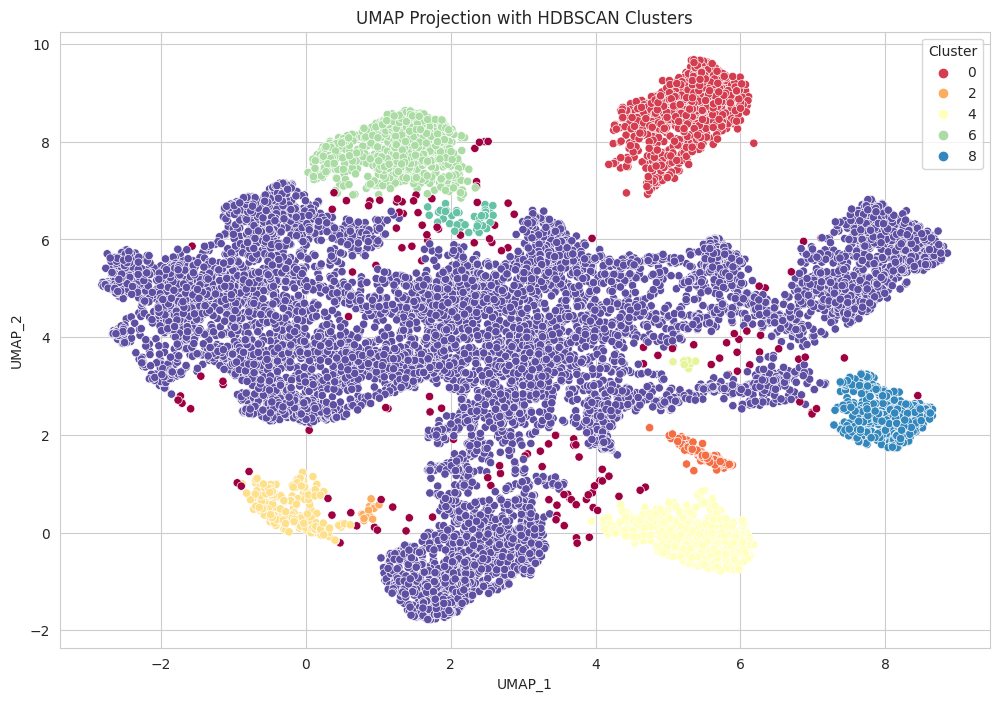

In [183]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=['UMAP_1', 'UMAP_2'])
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

Cluster 0 label distribution:
Original_Label
MC      1185
HGSC       5
LGSC       3
Name: count, dtype: int64



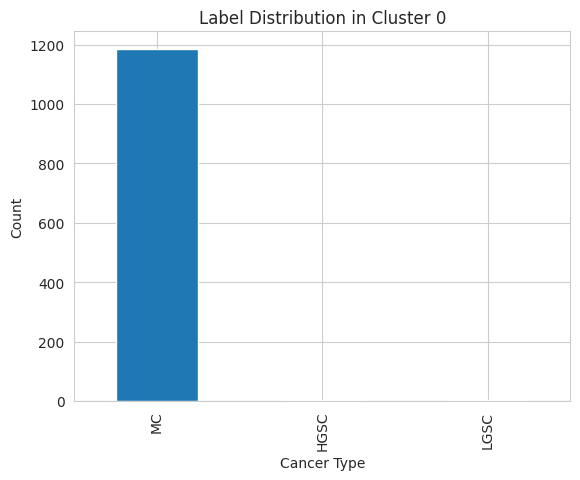

Cluster 1 label distribution:
Original_Label
EC    212
Name: count, dtype: int64



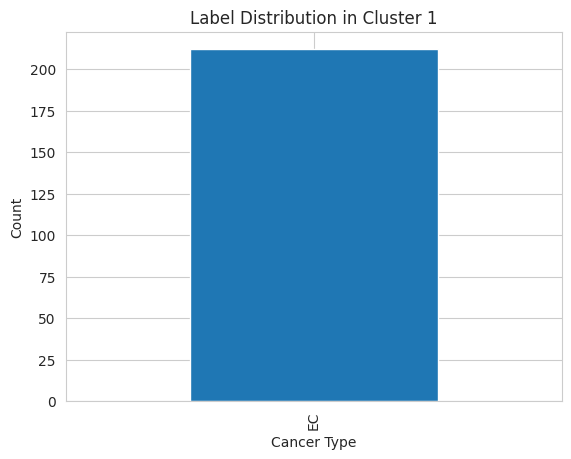

Cluster 2 label distribution:
Original_Label
CC    12
MC     1
Name: count, dtype: int64



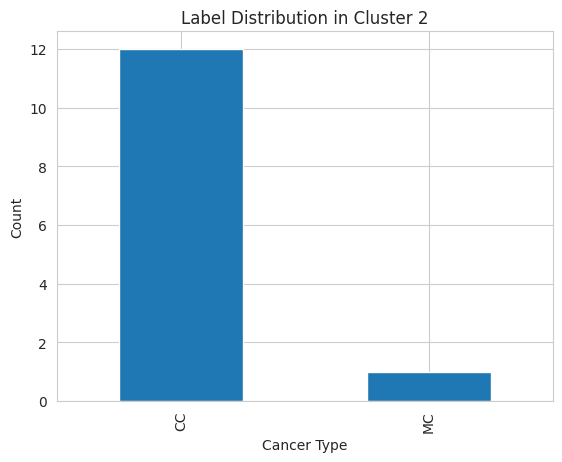

Cluster 3 label distribution:
Original_Label
CC      245
HGSC     14
EC        1
Name: count, dtype: int64



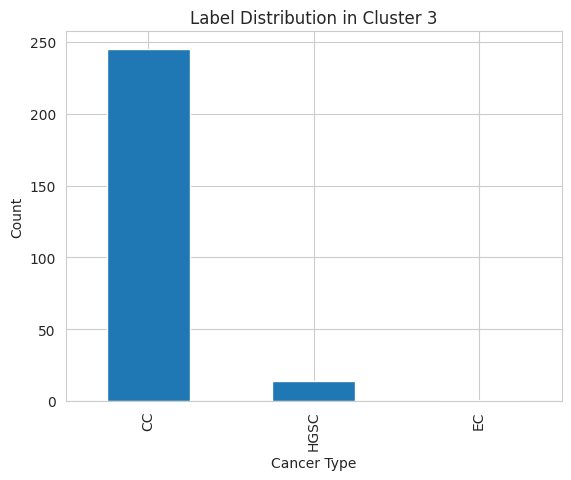

Cluster 4 label distribution:
Original_Label
MC      794
LGSC      6
EC        5
Name: count, dtype: int64



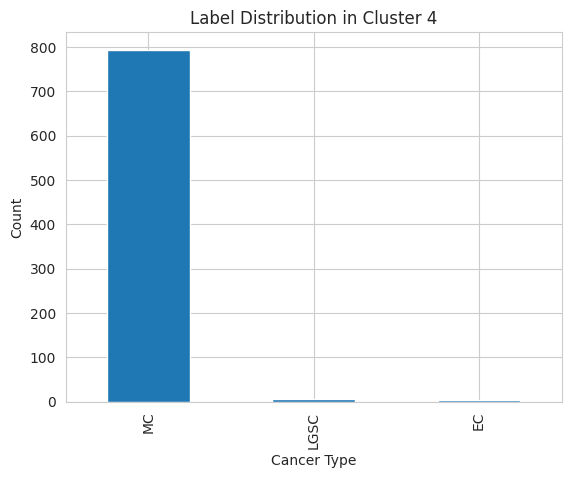

Cluster 5 label distribution:
Original_Label
MC      8
LGSC    1
EC      1
Name: count, dtype: int64



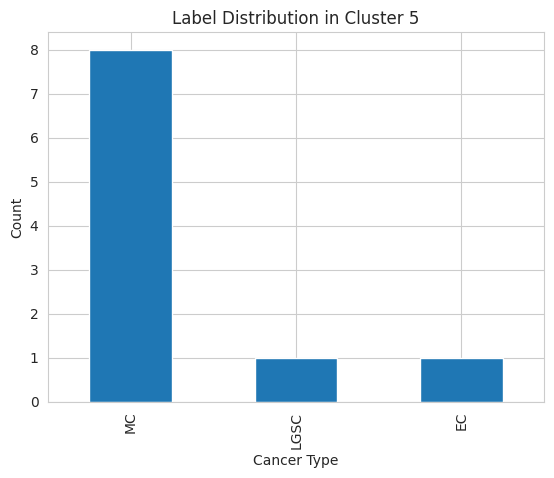

Cluster 6 label distribution:
Original_Label
HGSC    916
MC        9
LGSC      8
EC        7
CC        1
Name: count, dtype: int64



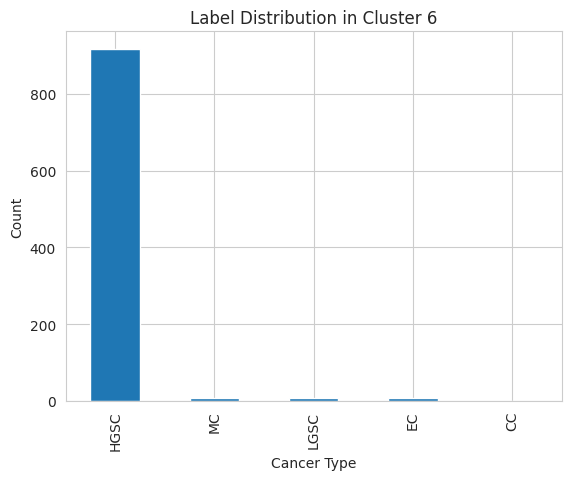

Cluster 7 label distribution:
Original_Label
HGSC    28
EC       8
LGSC     5
MC       2
Name: count, dtype: int64



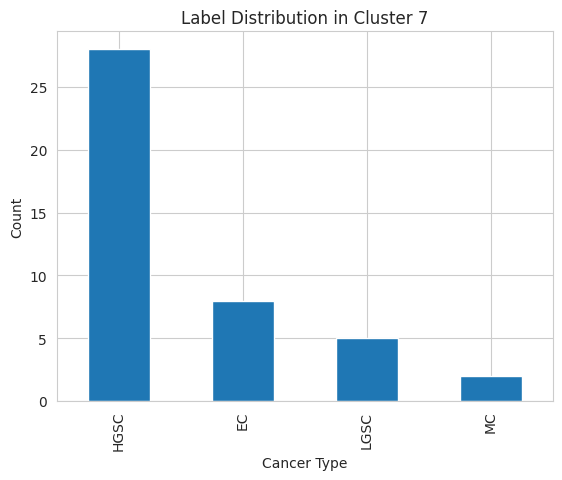

Cluster 8 label distribution:
Original_Label
MC    586
Name: count, dtype: int64



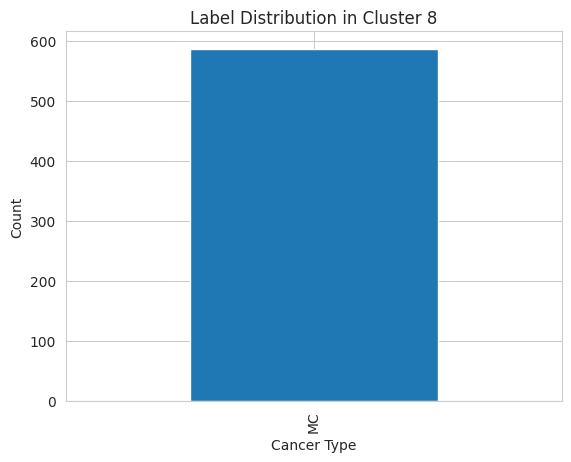

In [185]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Original_Label'] = train_labels

# Analyze the labels for each cluster
for cluster in range(0, 9):  # Assuming clusters are numbered 0 to 4
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()

### Select Representative Feature Vectors:
Select a fixed number of representative vectors from each cluster based on your clustering results.

In [197]:
num_representatives = 12  # Number of representatives to select from each cluster
representative_features = defaultdict(list)

for cluster in np.unique(cluster_labels_train):
    if cluster == -1:
        continue  # Skip the noise cluster (-1)
    if cluster == 5:
        continue  # Skip the noise cluster (-1)
    cluster_indices = np.where(cluster_labels_train == cluster)[0]
    selected_indices = np.random.choice(cluster_indices, num_representatives, replace=False)
    for idx in selected_indices:
        representative_features[cluster].append(train_features[idx])

### Augment training bags with representative features:
Now, using these representative feature vectors to augment the training bags in train_data.

In [198]:
augmented_train_data = []

for bag_features, label in train_data:
    augmented_bag = bag_features.copy()

    # Add representatives from each cluster to the bag
    for cluster_reps in representative_features.values():
        augmented_bag.extend(cluster_reps)
    
    augmented_train_data.append((augmented_bag, label))

### Create datasets and dataLoaders with augmented training data:
With the augmented training data, create MILDataset and DataLoader:

In [199]:
# Create a mapping from label strings to integers
unique_labels = sorted(set(label for _, label in data))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

class MILDataset(Dataset):
    def __init__(self, data, label_to_idx):
        self.data = data
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_vectors, label = self.data[idx]
        label_idx = self.label_to_idx[label]  # Convert label to integer
        return torch.tensor(feature_vectors), torch.tensor(label_idx, dtype=torch.float32)


# Creating the datasets with augmented training data
train_dataset = MILDataset(augmented_train_data, label_to_idx)
val_dataset = MILDataset(val_data, label_to_idx)
test_dataset = MILDataset(test_data, label_to_idx)

# DataLoaders remain the same
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model Training
Proceeding to train and test MIL model using this augmented training data.

In [200]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(AttentionMIL, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=0)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)  # num_classes instead of 1

    def forward(self, bag):
        h = torch.relu(self.fc1(bag))
        a = self.attention(h)
        v = torch.sum(a * h, dim=0)
        y = self.classifier(v)  # Remove softmax here; output raw scores
        return y, a

# Number of unique classes
num_classes = len(unique_labels)

model = AttentionMIL(input_dim=2048, hidden_dim=256, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model Training with Validation
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training loop
    for bags, labels in train_loader:
        optimizer.zero_grad()
        bags = bags.squeeze(0)  # Remove the extra dimension from bags
        labels = labels.squeeze(0).long()  # Remove extra dimension and ensure long type for labels
        output, _ = model(bags)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.squeeze(0)
            labels = labels.squeeze(0).long()
            output, _ = model(bags)
            loss = loss_function(output, labels)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/30, Train Loss: 1.7217, Validation Loss: 1.5666
Epoch 2/30, Train Loss: 1.5535, Validation Loss: 1.5720
Epoch 3/30, Train Loss: 1.5248, Validation Loss: 1.5617
Epoch 4/30, Train Loss: 1.5090, Validation Loss: 1.5462
Epoch 5/30, Train Loss: 1.4809, Validation Loss: 1.5529
Epoch 6/30, Train Loss: 1.4547, Validation Loss: 1.5129
Epoch 7/30, Train Loss: 1.4213, Validation Loss: 1.4764
Epoch 8/30, Train Loss: 1.3750, Validation Loss: 1.4826
Epoch 9/30, Train Loss: 1.3246, Validation Loss: 1.4249
Epoch 10/30, Train Loss: 1.2864, Validation Loss: 1.4128
Epoch 11/30, Train Loss: 1.2387, Validation Loss: 1.4000
Epoch 12/30, Train Loss: 1.2385, Validation Loss: 1.3621
Epoch 13/30, Train Loss: 1.1174, Validation Loss: 1.3603
Epoch 14/30, Train Loss: 1.0663, Validation Loss: 1.3430
Epoch 15/30, Train Loss: 1.0456, Validation Loss: 1.2922
Epoch 16/30, Train Loss: 1.0194, Validation Loss: 1.3116
Epoch 17/30, Train Loss: 0.9406, Validation Loss: 1.3039
Epoch 18/30, Train Loss: 0.8958, Validat

# Evaluation
Testing results of trained model

In [205]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for bags, labels in test_loader:
        output, _ = model(bags.squeeze(0))
        _, predicted_labels = torch.max(output, 0)  # Get the index of the max log-probability
        predictions.append(predicted_labels.item())  # Append scalar value
        true_labels.append(labels.squeeze(0).item())  # Append scalar value

# Convert lists to arrays for metric calculation
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.4444
Precision: 0.5500
Recall: 0.4000
F1 Score: 0.3667


In [202]:
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Use idx_to_label to map numeric predictions back to label names
predicted_labels = [idx_to_label[int(idx)] for idx in predictions]
true_label_names = [idx_to_label[int(idx)] for idx in true_labels]

# Now predicted_labels and true_label_names contain the label names
print(predicted_labels)
print(true_label_names)

['CC', 'LGSC', 'LGSC', 'MC', 'HGSC', 'HGSC', 'MC', 'MC', 'MC']
['EC', 'LGSC', 'MC', 'MC', 'HGSC', 'HGSC', 'LGSC', 'CC', 'EC']
